# Set-up
---

##Installing packages not pre-installed on Colab

In [1]:
# Installing the needed packages not installed by default
# !pip install pyLDAvis==3.2.1
!pip install afinn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 KB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53447 sha256=8a15fda71b64a91cb4971e8473fe661f71de9eb84dc7f895398d580dc95eb812
  Stored in directory: /root/.cache/pip/wheels/f6/6f/c3/b305c5107a17618f2938a067d5ffcbb556909d82398762089e
Successfully built afinn


## Importing packages


In [2]:
import numpy as np
import numpy.random as random
import pandas as pd
import matplotlib.pyplot as plt

##Loading the data

In [3]:
# Loading the data
data_all = pd.read_csv('https://github.com/zarkem/emiba-ai/blob/main/las_vegas_restaurants_2017.csv?raw=true')
# Removing some unused columns
data_all = data_all.loc[:, data_all.columns != 'Unnamed: 0']


## Preprocess Text for Word Cloud

In [4]:
# Text manipulation
import re

import gensim  # gensim for NLP models
import gensim.corpora as corpora
from gensim.utils import simple_preprocess

# NLTK Stop words
import nltk  # For getting stop words
nltk.download('stopwords')  # Downloading them
from nltk.corpus import stopwords

# spacy 
import spacy  # For the lemmatization

# Function for cleaning the dataset
def clean_data(df):
  df = [re.sub(r'\S*@\S*\s?', '', sent) for sent in df]  # Removing e-mail addresses
  df = [re.sub(r'\s+', ' ', sent) for sent in df]  # Removing break lines
  df = [re.sub("\'", "", sent) for sent in df]  # Removing simple quotation mark
  df = [re.sub("-", " ", sent) for sent in df]  # Removing simple hyphens
  df = [re.sub(":", "", sent) for sent in df]  # Removing colons
  return df

# Processing the texts
df = data_all['text'].tolist() 
df = clean_data(df)

# Converting them to a unique sentence
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
df_words = list(sent_to_words(df))

# Identifying the common words (we can consider them as stop words)
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use','a','about', 'above', 'across'])

# Creating the model based in bigrams and trigrams
bigram = gensim.models.Phrases(df_words, min_count=5, threshold=100)  # Set the min and max number of words
trigram = gensim.models.Phrases(bigram[df_words], threshold=100)  

# Converting the words to a bigram and trigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Function for removing the common words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# Creating the bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Creating the tigrams
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

# Keeping just the lemmas
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [6]:
# Processing the text reviews

# Removing stop words
data_words_nostops = remove_stopwords(df_words)
# Creating bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Loading the lemmatization model
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
# Selecting names, adjectives, verbs and adverbs
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

## Adding the processed text to the dataframe
processed_text = pd.Series((i for i in data_lemmatized))
processed_text = processed_text.apply(lambda x: ' '.join(str(elem) for elem in x))
data_all.loc[:, 'processed_text'] = processed_text
data_all.drop('review_count', axis=1, inplace=True)
print(data_all.processed_text.head(15))

0     display glass case baklava ravani always impec...
1     hear local grape vine chef leave milo create m...
2     place hit spot takeout disappoint baklava sit ...
3     go lunch recommendation good say come pretty d...
4     hear constant noise restaurant week pass sever...
5     good greek food las_vegas long time falafel fa...
6     m shock say wife craving greek decide forgo us...
7     meraki truly amazing i d start staff polite kn...
8     hand new favorite greek restaurant town portio...
9     sister check place go rush see place busy food...
10    great food great owner care customer staff fri...
11    great place quick lunch place month old look n...
12    wait place open finally get try today definite...
13    today first visit lot greek place town stand g...
14    return road trip famish meet friend different ...
Name: processed_text, dtype: object


##Defining re-used general functions

In [7]:
# Functions for plotting histograms

def compute_histogram_bins(data, desired_bin_size):
    """ Internal function used to compute the bins according to their desired size """
    min_val = np.min(data)
    max_val = np.max(data)
    min_boundary = -1.0 * (min_val % desired_bin_size - min_val)
    max_boundary = max_val - max_val % desired_bin_size + desired_bin_size
    n_bins = int(round((max_boundary - min_boundary) / desired_bin_size, 0)) + 1
    bins = np.linspace(min_boundary, max_boundary, n_bins)
    return bins

def plot_sentiment_counts(data, bin_width):
    """ Creates a histogram of the count values listed in 'data' creating the desired bins """
    bins = compute_histogram_bins(data, bin_width)
    plt.hist(data, bins=bins)
    plt.xlabel('Sentiment')
    plt.ylabel('Number of reviews')
    plt.title('Sentiment by number of reviews')
    plt.grid(True)  # plot histogram with gridlines
    plt.show()  # display the plot

# from matplotlib.ticker import PercentFormatter
def NOT_USED_plot_sentiment_percentage(data, bin_width):
    """ Creates a histogram of the percentage values listed in 'data' creating the desired bins """
    bins= compute_histogram_bins(data, bin_width)
    plt.hist(data, bins=bins, weights=np.ones(len(data)) / len(data), color='green') # apply equal weight to each sentiment value
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1)) # format the y-axis to show proportions as percentage
    plt.xlabel('Sentiment')
    plt.ylabel('Percentage of reviews')
    plt.title('Sentiment by Percentage of reviews')
    plt.grid(True) # plot histogram with gridlines
    plt.show() #display the plot

#Overview of the Yelp Dataset

---

## Understanding the data


In [8]:
# Main info
print(f'There are {data_all.shape[0]} reviews of {data_all["business_id"].nunique()} restaurants with 5 stars in Las Vegas.')
print('These are the descriptives of numerical variables:')
display(data_all.describe())

print('Sample of the first reviews:')
display(data_all.head())

print('Example of the full text of one specific review:')
print(data_all.iloc[0]['text'])
print('\n', data_all.iloc[0]['processed_text'])

There are 2730 reviews of 119 restaurants with 5 stars in Las Vegas.
These are the descriptives of numerical variables:


overall_rating  review_rating
count          2730.0    2730.000000
mean              5.0       4.830403
std               0.0       0.555619
min               5.0       1.000000
25%               5.0       5.000000
50%               5.0       5.000000
75%               5.0       5.000000
max               5.0       5.000000

Sample of the first reviews:


business_id                  name   neighborhood       city  \
0  L1-1P3acJc4gEFvWwjXcNQ  "Meraki Greek Grill"  Spring Valley  Las Vegas   
1  L1-1P3acJc4gEFvWwjXcNQ  "Meraki Greek Grill"  Spring Valley  Las Vegas   
2  L1-1P3acJc4gEFvWwjXcNQ  "Meraki Greek Grill"  Spring Valley  Las Vegas   
3  L1-1P3acJc4gEFvWwjXcNQ  "Meraki Greek Grill"  Spring Valley  Las Vegas   
4  L1-1P3acJc4gEFvWwjXcNQ  "Meraki Greek Grill"  Spring Valley  Las Vegas   

  state  overall_rating         categories               review_id  \
0    NV             5.0  Restaurants;Greek  kaSiZ4cDXpeCtkhL2ztlDg   
1    NV             5.0  Restaurants;Greek  xQ7lS9VjG4nHlf5nCZEglA   
2    NV             5.0  Restaurants;Greek  763gLfjrxKB0pJNtmQQ94g   
3    NV             5.0  Restaurants;Greek  DFFzcQnyTcqFqMfzibEc6w   
4    NV             5.0  Restaurants;Greek  WVa8NmPPlaIONN79OqR2CQ   

   review_rating        date  \
0              5  2017-10-24   
1              5  2017-03-23   
2              4  2017-04-16   
3              4  2017-07-29   
4              5  2017-06-07   

                                                text  \
0  Displayed in a glass case are delicious baklav...   
1  I heard through the local grape vine that Chef...   
2  This place hit the spot for a takeout. Was dis...   
3  Went here for lunch on a recommendation as "th...   
4  I had been hearing CONSTANT noise about this r...   

                                      processed_text  
0  display glass case baklava ravani always impec...  
1  hear local grape vine chef leave milo create m...  
2  place hit spot takeout disappoint baklava sit ...  
3  go lunch recommendation good say come pretty d...  
4  hear constant noise restaurant week pass sever...

Example of the full text of one specific review:
Displayed in a glass case are delicious baklava & ravani. Both the baklava & ravani are always impeccably fresh, as are all of Meraki's menu items.  The baklava & ravani are there as you order, so go ahead and order one of each. you won't regret it!  
Meraki has traditional Greek cuts, always tender, robust and basted with lemon, Greek olive oil and various herbs.  They offer classic gyros and are always spot on! 
The Greek spreads such as tzatziki are always consistent and hit the spot!  Who can resist not ordering garlic and cucumbers;)   Perhaps when you first try Meraki May I suggest ordering the combo of spreads.  
The staff exudes enthusiasm and ask away for dining recommendations.

 display glass case baklava ravani always impeccably fresh meraki menu item ravani order go ahead order meraki traditional greek cut always tender robust baste lemon greek various herb offer classic gyro always spot greek spread always consistent hit sp

Let's see the distribution of the number of reviews per restaurant.

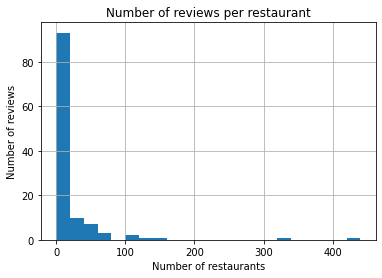

In [9]:
nrevs = data_all['business_id'].value_counts()


bins = compute_histogram_bins(nrevs, 20)
plt.hist(nrevs, bins = bins)
plt.xlabel('Number of restaurants')
plt.ylabel('Number of reviews')
plt.title('Number of reviews per restaurant')
plt.grid(True)  # plot histogram with gridlines
plt.show()  # display the plot


#Overview of the Class Dataset

---

##Selecting a subset with the most reviewed restaurants

Define a new DataFrame named ```data_class``` with the reviews of restaurants having at least ```min_reviews``` reviews.


In [10]:
# Your code here
min_reviews = 20
data_class = data_all.groupby("business_id").filter(lambda x: x['business_id'].size >= min_reviews )


In [11]:
# Main statistics
display(data_class.describe())

print("\nNumber and average of reviews by restaurant:")
display(data_class.groupby(['name','business_id'])['review_rating'].agg(['count', 'mean']))



overall_rating  review_rating
count          2111.0    2111.000000
mean              5.0       4.813832
std               0.0       0.577557
min               5.0       1.000000
25%               5.0       5.000000
50%               5.0       5.000000
75%               5.0       5.000000
max               5.0       5.000000


Number and average of reviews by restaurant:


count      mean
name                                  business_id                            
"Bajamar Seafood & Tacos"             G4hjhtA_wQ-tSOGpgGlDjw     43  4.767442
"Boqueria Street"                     xAhB_i6-799TakpGqVplWw     20  4.850000
"Bosa Boba Cafe"                      qw9SyduMZ53KB6GlBQqvZQ     55  4.890909
"Brew Tea Bar"                        IhNASEZ3XnBHmuuVnWdIwA    433  4.863741
"California Sushi Burrito"            wZkjm9TGa7nXLYHxhIRO5w     57  4.807018
"Cheba Hut"                           sAZGdlYTp41UWEjHdeZrWg     41  4.853659
"Chupy's Mexican Restaurant"          UNHvM2pc7AQBL22BhakNlA     21  4.761905
"El Cachi Mexican Kitchen"            rbWL5eZCaHLqhpLd84xwUg     21  4.857143
"El Pollo Mobile"                     2wv9ocE3VS2MbBRany2Zyw     26  4.730769
"El Zarape Mexican Restaurant"        mzQLni03qPCPxkUXQ52U_Q     24  4.875000
"Fresh Sub"                           G03yt8WuN1v0bCD8mvoDiA     55  4.763636
"J Karaoke Bar"                       3pSUr_cdrphurO6m1HMP9A    105  4.676190
"Kame Omakase"                        9P23-V64kYz3trn9ecaJJA     46  4.782609
"LUV Lounge"                          aEtbk_LuJREjm66jKmCQRw     26  4.807692
"Lip Smacking Foodie Tours"           iBPyahdJRP5y0t25fF2W9w     79  4.962025
"Me Gusta Tacos"                      N95IG-T9bbR2iNL9_an1SQ     30  4.766667
"Meraki Greek Grill"                  L1-1P3acJc4gEFvWwjXcNQ    326  4.797546
"Niko's Pizza Las Vegas"              E_jLyf_YuGgMP_rw8tvNSA    112  4.767857
"Pie Me Over"                         32JWhoH-Kiu1wRFTvHvW9Q     33  5.000000
"Salud Mexican Bistro and Tequileria" zN4f3aLeCuIhCTPRH0di-A     70  4.757143
"Smooth Eats"                         1CaM8eIvl41l4f3V-V-cAw     57  4.807018
"Sushi Hiroyoshi Japanese Cuisine"    vOMDU31gdylrzBhAKC9QbA     79  4.734177
"Tacos Huevos"                        GzBIAjAMHD9iVZK8BT6XMw    133  4.774436
"Taste - Homestyle Indian Kitchen"    2B4bC4w4PDC8Pj53SfTG2g     30  4.900000
"Toddy Shop"                          -CQokjildrY7UZezXCdEBw     34  4.764706
"Zenaida's Cafe"                      8fFTJBh0RB2EKG53ibiBKw    155  4.832258

##Words




In [12]:
import re  # Text manipulation
import PIL  # Convert image to array for manipulation
import wordcloud  # Wordcloud library
import numpy as mp  # Array manipulation
from urllib.request import urlopen  # open url

# We define the function to visualize the word cloud
def plot_cloud(wordcloud_var):
    plt.figure(figsize=(40, 30))  # Define the size
    plt.imshow(wordcloud_var)  # Show the image
    plt.axis("off");  # We don't want axes

# We created a word cloud of all the restaurants

# Image as the background shape
with urlopen("https://raw.githubusercontent.com/zarkem/emiba-ai/main/upvote.png") as conn:
   mask = np.array(PIL.Image.open(conn)) # Generate wordcloud ('comment.png', 'loc.png', 'star.png', 'upvote.png', 'user.png')

# Function to plot the word cloud
def plot_wordcloud(dataset):
  text = dataset.processed_text.str.cat(sep=' ')
  wordcloud_var = wordcloud.WordCloud(width = 3000,  # change the dimension of the word cloud to your preferred width
                        height = 2000,  # change the dimension of the word cloud to your preferred height
                        random_state=1,  #  Used to get the same word cloud and avoid randomness
                        background_color='white',  # Modify the background color of 'white' and 'black'
                        colormap='rainbow', # You can set the color theme in which the words are displayed ( 'rainbow', 'seismic', 'Pastel1' and Pastel2')
                        collocations=False,  # Set this to False to ensure that the word cloud does not appear to contain duplicate words
                        stopwords = wordcloud.STOPWORDS,  # Stopwords are common words that provide little or no value to the meaning of the text
                        mask=mask).generate(text)  # Plot
  plot_cloud(wordcloud_var)



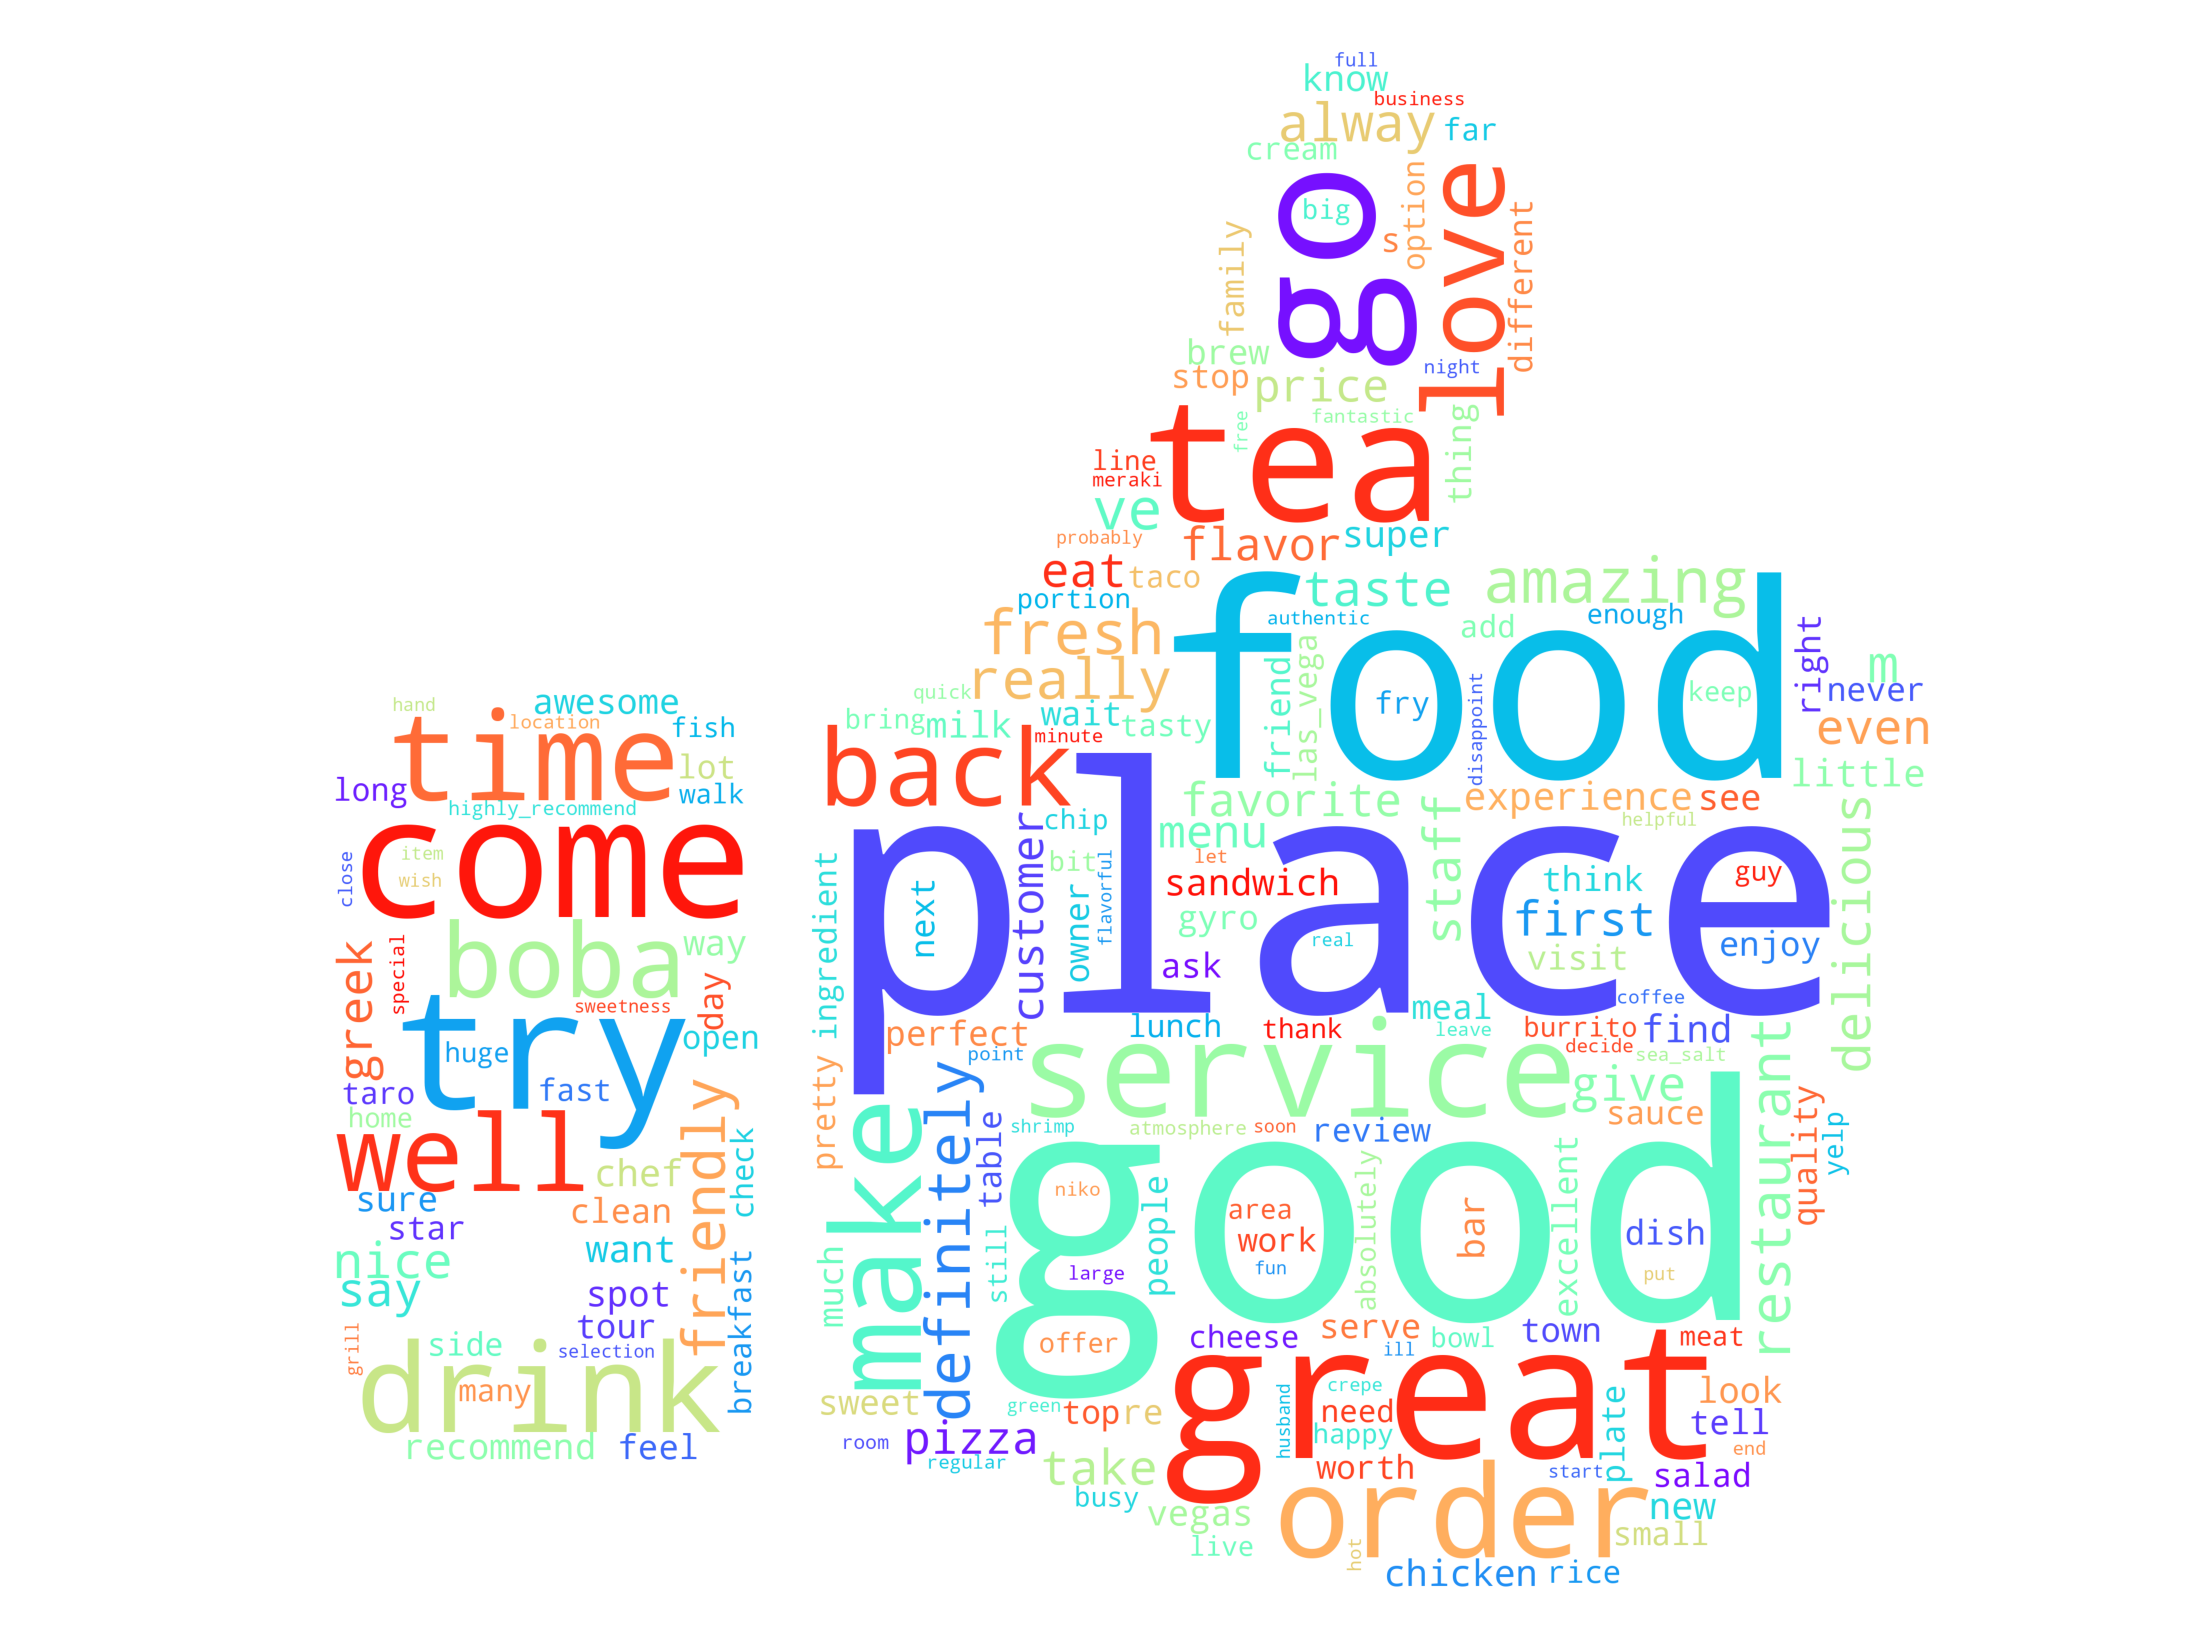

In [13]:
# Take care: it can spend about 1 minute!
plot_wordcloud(data_class)


## Computing and understanding affinity score (sentiment)




In [14]:
# For computing affinity score
from afinn import Afinn

# Sentiment analysis with Afinn
afinn = Afinn()
data_class.loc[:, 'afinn_score'] = data_class.loc[:, 'processed_text'].apply(afinn.score)


the mean sentiment is 12.358124111795357
the mean positive sentiment is 12.660386473429952
the mean negative sentiment is -2.902439024390244
the number of positive sentiment is 2070
the number of negative sentiment is 41
These are the descriptives of the sentiment:


count    2111.000000
mean       12.358124
std         8.759322
min       -12.000000
25%         7.000000
50%        11.000000
75%        16.000000
max        72.000000
Name: afinn_score, dtype: float64

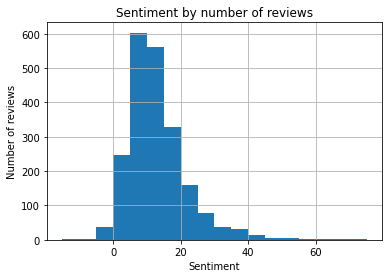

In [15]:
# Distribution of affinity score
def display_sentiment_inf(dataset):

  # Average and count of positive and negative reviews
  mean_sent_pos = dataset[dataset['afinn_score']>=0]['afinn_score'].mean()
  mean_sent_neg = dataset[dataset['afinn_score']<0]['afinn_score'].mean()
  count_sent_pos = dataset[dataset['afinn_score']>=0]['afinn_score'].count()
  count_sent_neg = dataset[dataset['afinn_score']<0]['afinn_score'].count()

  print('the mean sentiment is ' + str(dataset['afinn_score'].mean()))
  print('the mean positive sentiment is ' + str(mean_sent_pos))
  print('the mean negative sentiment is ' + str(mean_sent_neg))
  print('the number of positive sentiment is ' + str(count_sent_pos))
  print('the number of negative sentiment is ' + str(count_sent_neg))

  # display sentiment descriptors
  print('These are the descriptives of the sentiment:')
  display(dataset['afinn_score'].describe())

  # show the distribution of sentiment
  plot_sentiment_counts(dataset.afinn_score, 5.0)
  #plot_sentiment_percentage(dataset.afinn_score, 5.0)

display_sentiment_inf(data_class)

## Words by Sentiment

In [16]:
 def display_words_by_sentiment(dataset):

  # texto de cliente por tema
  sent_pos = dataset.loc[dataset['afinn_score']>=0,'processed_text']
  sent_neg = dataset.loc[dataset['afinn_score']<0,'processed_text']

  # trazar el texto por tema
  sentiment_list= {'positive_sentiment': sent_pos, 'negative_sentiment': sent_neg}
  for k,v in sentiment_list.items():
      review_text= v
      print('Words in reviews related to ' + k)
      #Creamos una nube de palabras para cada tema
      text = review_text.str.cat(sep=' ')

      wordcloud_var = wordcloud.WordCloud(width = 3000,  # change the dimension of the word cloud to your preferred width
                        height = 2000,  # change the dimension of the word cloud to your preferred height
                        random_state=1,  #  Used to get the same word cloud and avoid randomness
                        background_color='white',  # Modify the background color of 'white' and 'black'
                        colormap='rainbow', # You can set the color theme in which the words are displayed ( 'rainbow', 'seismic', 'Pastel1' and Pastel2')
                        collocations=False,  # Set this to False to ensure that the word cloud does not appear to contain duplicate words
                        stopwords = wordcloud.STOPWORDS,  # Stopwords are common words that provide little or no value to the meaning of the text
                        mask=mask).generate(text)  # Plot

      plot_cloud(wordcloud_var)


Words in reviews related to positive_sentiment
Words in reviews related to negative_sentiment


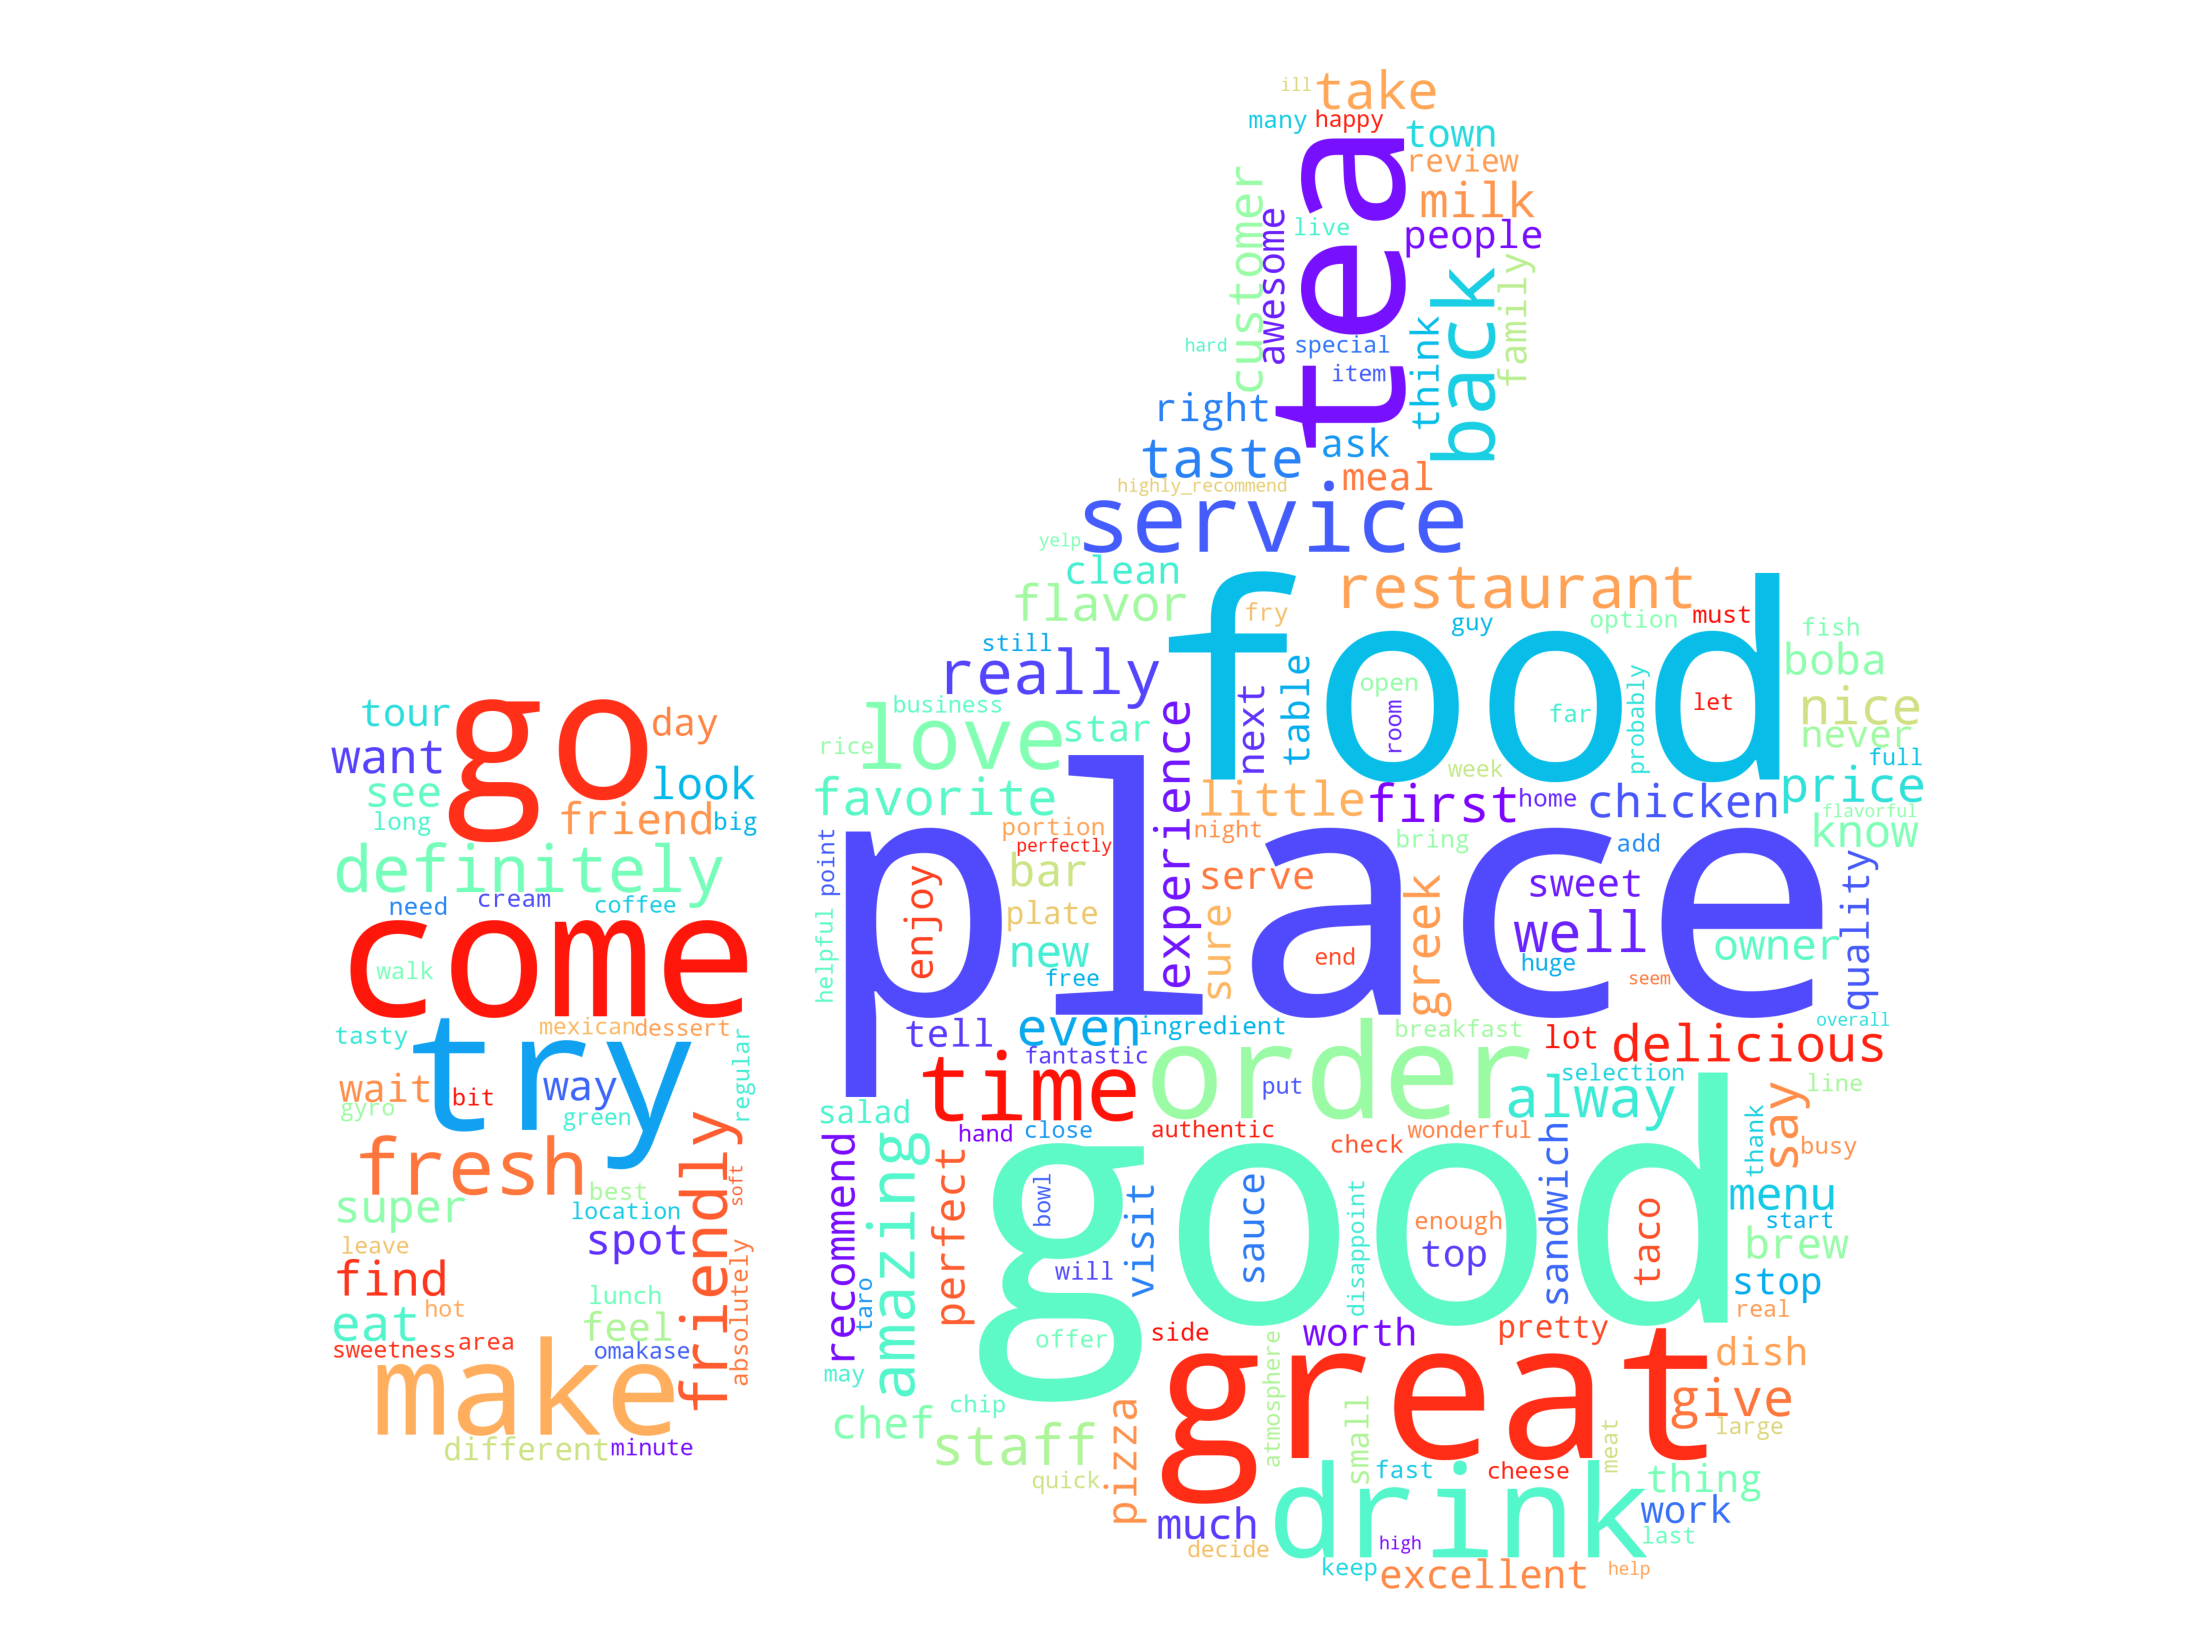

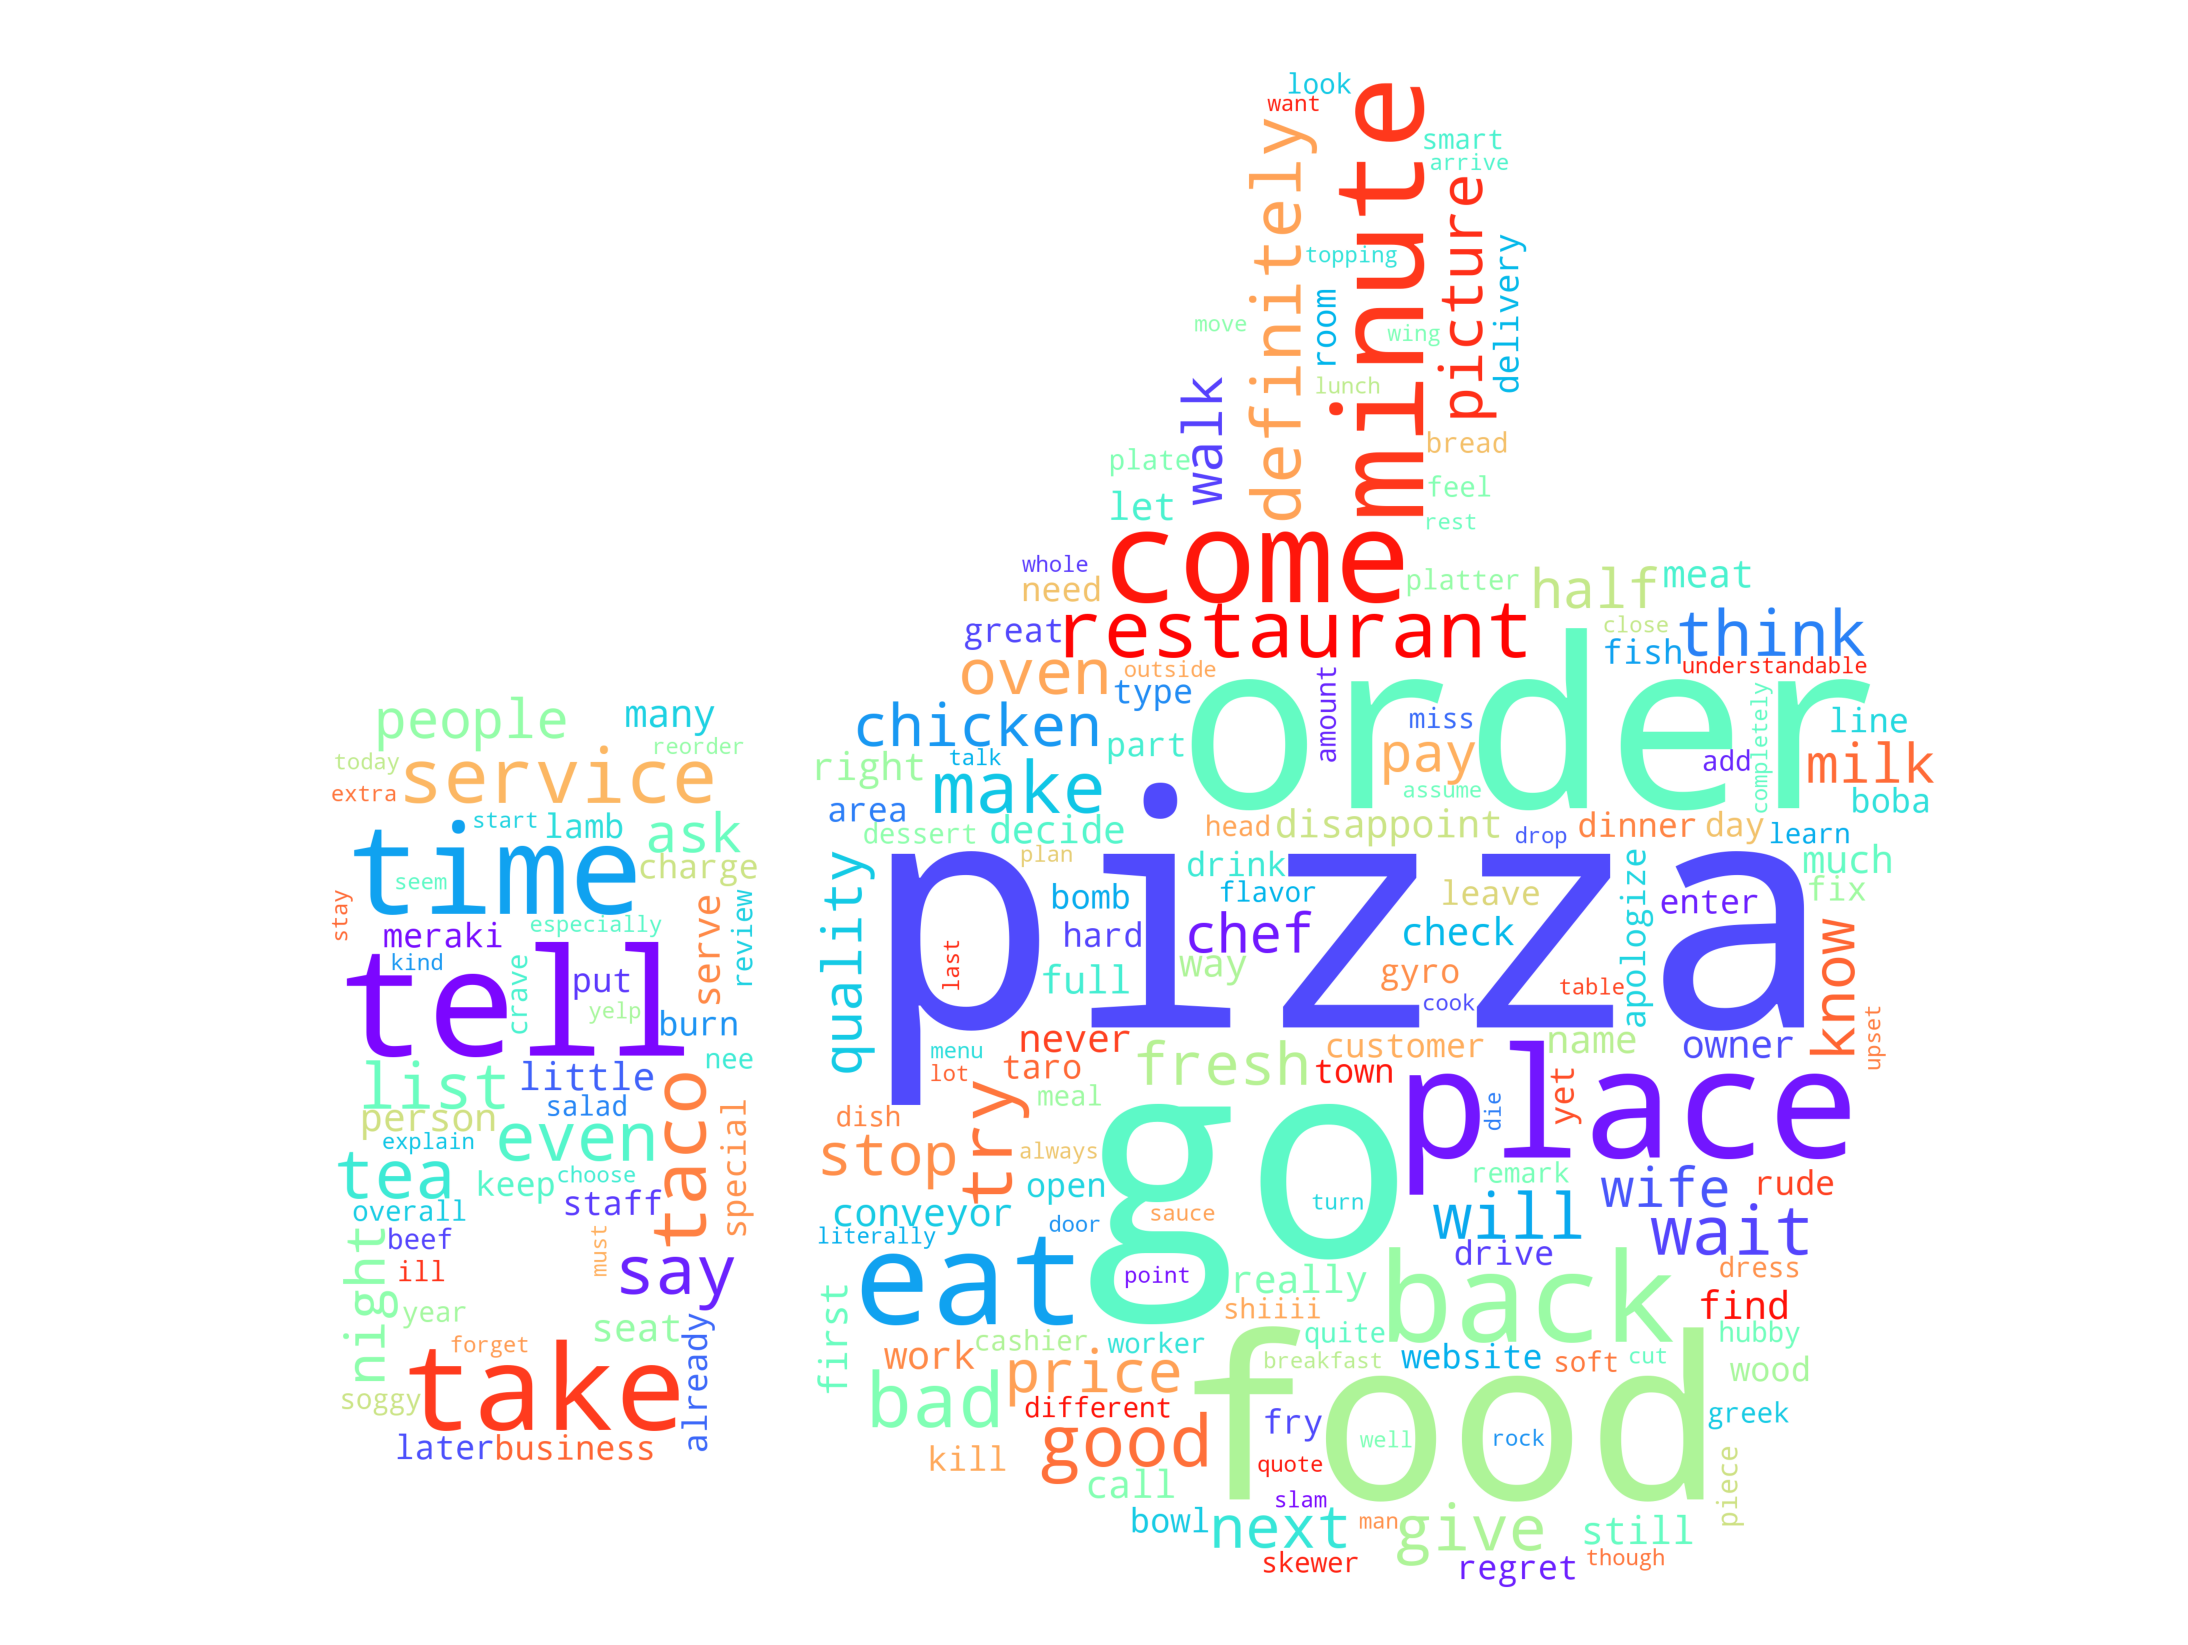

In [ ]:
 display_words_by_sentiment(data_class)

# Computing a rank

Define a rank of restaurants according to the affinity score of their reviews. Create a DataFrame with one column containing the identifier of the restaurant and one column with the aggregated affinity score of the restaurant.


In [20]:
# Your code here
data_afinn = data_class.groupby(['name','business_id'], as_index=False).mean()[['name','business_id', 'afinn_score']]
data_afinn.sort_values(by=['afinn_score'], ascending=False)

list_affin = list(range(1,data_afinn.shape[0]+1))
data_afinn['rank'] = list_affin
data_afinn


name             business_id  \
0               "Bajamar Seafood & Tacos"  G4hjhtA_wQ-tSOGpgGlDjw   
1                       "Boqueria Street"  xAhB_i6-799TakpGqVplWw   
2                        "Bosa Boba Cafe"  qw9SyduMZ53KB6GlBQqvZQ   
3                          "Brew Tea Bar"  IhNASEZ3XnBHmuuVnWdIwA   
4              "California Sushi Burrito"  wZkjm9TGa7nXLYHxhIRO5w   
5                             "Cheba Hut"  sAZGdlYTp41UWEjHdeZrWg   
6            "Chupy's Mexican Restaurant"  UNHvM2pc7AQBL22BhakNlA   
7              "El Cachi Mexican Kitchen"  rbWL5eZCaHLqhpLd84xwUg   
8                       "El Pollo Mobile"  2wv9ocE3VS2MbBRany2Zyw   
9          "El Zarape Mexican Restaurant"  mzQLni03qPCPxkUXQ52U_Q   
10                            "Fresh Sub"  G03yt8WuN1v0bCD8mvoDiA   
11                        "J Karaoke Bar"  3pSUr_cdrphurO6m1HMP9A   
12                         "Kame Omakase"  9P23-V64kYz3trn9ecaJJA   
13                           "LUV Lounge"  aEtbk_LuJREjm66jKmCQRw   
14            "Lip Smacking Foodie Tours"  iBPyahdJRP5y0t25fF2W9w   
15                       "Me Gusta Tacos"  N95IG-T9bbR2iNL9_an1SQ   
16                   "Meraki Greek Grill"  L1-1P3acJc4gEFvWwjXcNQ   
17               "Niko's Pizza Las Vegas"  E_jLyf_YuGgMP_rw8tvNSA   
18                          "Pie Me Over"  32JWhoH-Kiu1wRFTvHvW9Q   
19  "Salud Mexican Bistro and Tequileria"  zN4f3aLeCuIhCTPRH0di-A   
20                          "Smooth Eats"  1CaM8eIvl41l4f3V-V-cAw   
21     "Sushi Hiroyoshi Japanese Cuisine"  vOMDU31gdylrzBhAKC9QbA   
22                         "Tacos Huevos"  GzBIAjAMHD9iVZK8BT6XMw   
23     "Taste - Homestyle Indian Kitchen"  2B4bC4w4PDC8Pj53SfTG2g   
24                           "Toddy Shop"  -CQokjildrY7UZezXCdEBw   
25                       "Zenaida's Cafe"  8fFTJBh0RB2EKG53ibiBKw   

    afinn_score  rank  
0     11.395349     1  
1     13.750000     2  
2     11.400000     3  
3     12.639723     4  
4     11.122807     5  
5     12.390244     6  
6     15.761905     7  
7     10.285714     8  
8      8.230769     9  
9     10.500000    10  
10     9.254545    11  
11    11.657143    12  
12    13.000000    13  
13    10.538462    14  
14    15.569620    15  
15    14.933333    16  
16    12.950920    17  
17    11.276786    18  
18    11.757576    19  
19    12.328571    20  
20    13.280702    21  
21    14.544304    22  
22    10.481203    23  
23     8.600000    24  
24    12.823529    25  
25    13.258065    26

# Select a restaurant to analyze

The idea of this second part is to choose one the available restaurants and advise the restaurand owner.

In [21]:
# Choose a number between 0 and 25
selected_restaurant = 11

In [22]:
ids = data_class['business_id'].unique()
if (selected_restaurant < 0 | selected_restaurant >= len(ids)):
    print('Invalid selection.\n')
selected_id = ids[selected_restaurant]

In [23]:
# filter only the reviews that pertains to the restaurant
data = data_class.loc[data_class['business_id']==selected_id, :]
restaurant_name = data.iloc[0]['name']
data

business_id             name neighborhood       city state  \
1504  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1505  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1506  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1507  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1508  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
...                      ...              ...          ...        ...   ...   
1604  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1605  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1606  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1607  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1608  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   

      overall_rating                                         categories  \
1504             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1505             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1506             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1507             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1508             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
...              ...                                                ...   
1604             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1605             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1606             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1607             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1608             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   

                   review_id  review_rating        date  \
1504  bYxyCBHwRUYKPUj8hKHBtA              5  2017-10-26   
1505  NChMiA7sFl0ebxp7hMDeSQ              5  2017-07-05   
1506  BRIrLLnZXZMp19HoW_Mv5g              4  2017-10-24   
1507  zDOJ-_UC5-H-XlPJz7ezyQ              5  2017-09-29   
1508  hOxmEwIv5steGODytunEjw              5  2017-07-09   
...                      ...            ...         ...   
1604  ZMDICia1FkuYVAZ8vZSqeg              5  2017-07-09   
1605  SQrpVXYTnTtCGX151U1Mqw              4  2017-10-01   
1606  jpykCJyqPpxNoMXVRH9lzw              4  2017-08-08   
1607  LYKcGr0a6u51uN36Ic_aCw              5  2017-09-02   
1608  InrSoxochsSV9Wx6FpRdag              5  2017-02-15   

                                                   text  \
1504  Love it here so much fun nice  karaoke place i...   
1505  Awesome vibe. Love the manager named Antonio! ...   
1506  Cheap drunk food that's perfect to keep the ni...   
1507  Always a good time here. Quick service and str...   
1508  Omg! So much fun! Came with a group of people ...   
...                                                 ...   
1604  This is my first time here and this one of the...   
1605  Good atmosphere but still a bit small on song ...   
1606  Always a good time with great food, I enjoy ho...   
1607  Great place to be! Jim is a great sever\/host!...   
1608  Always a good time with family and friends! Gr...   

                                         processed_text  afinn_score  
1504  love much fun nice karaoke place town definite...         10.0  
1505  awesome vibe love manager name m come way turl...         13.0  
1506  cheap drunk food s perfect keep night go bar o...         18.0  
1507  always good time quick service strong drink fo...          8.0  
1508  omg much fun come group people amaze great ser...         38.0  
...                                                 ...          ...  
1604  first time good experience ve staff amazing ef...         12.0  
1605  good atmosphere still bit small song selection...          4.0  
1606  always good time great food enjoy sound system...         10.0  
1607  great place great sever host come

#Overview of the Restaurant

## Main information

In [24]:
# Main info
print(f'There are {data.shape[0]} reviews of {data["business_id"].nunique()} restaurants with 5 stars in Las Vegas.')
print('These are the descriptives of numerical variables:')
display(data.describe())

print('Sample of the first reviews:')
display(data.head())

print('Example of the full text of one specific review:')
print(data.iloc[0]['text'])
print('\n', data.iloc[0]['processed_text'])

There are 105 reviews of 1 restaurants with 5 stars in Las Vegas.
These are the descriptives of numerical variables:


overall_rating  review_rating  afinn_score
count           105.0     105.000000   105.000000
mean              5.0       4.676190    11.657143
std               0.0       0.753138     8.214467
min               5.0       1.000000    -5.000000
25%               5.0       5.000000     6.000000
50%               5.0       5.000000    11.000000
75%               5.0       5.000000    16.000000
max               5.0       5.000000    38.000000

Sample of the first reviews:


business_id             name neighborhood       city state  \
1504  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1505  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1506  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1507  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   
1508  3pSUr_cdrphurO6m1HMP9A  "J Karaoke Bar"    Chinatown  Las Vegas    NV   

      overall_rating                                         categories  \
1504             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1505             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1506             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1507             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   
1508             5.0  Bars;American (New);Karaoke;Nightlife;Asian Fu...   

                   review_id  review_rating        date  \
1504  bYxyCBHwRUYKPUj8hKHBtA              5  2017-10-26   
1505  NChMiA7sFl0ebxp7hMDeSQ              5  2017-07-05   
1506  BRIrLLnZXZMp19HoW_Mv5g              4  2017-10-24   
1507  zDOJ-_UC5-H-XlPJz7ezyQ              5  2017-09-29   
1508  hOxmEwIv5steGODytunEjw              5  2017-07-09   

                                                   text  \
1504  Love it here so much fun nice  karaoke place i...   
1505  Awesome vibe. Love the manager named Antonio! ...   
1506  Cheap drunk food that's perfect to keep the ni...   
1507  Always a good time here. Quick service and str...   
1508  Omg! So much fun! Came with a group of people ...   

                                         processed_text  afinn_score  
1504  love much fun nice karaoke place town definite...         10.0  
1505  awesome vibe love manager name m come way turl...         13.0  
1506  cheap drunk food s perfect keep night go bar o...         18.0  
1507  always good time quick service strong drink fo...          8.0  
1508  omg much fun come group people amaze great ser...         38.0

Example of the full text of one specific review:
Love it here so much fun nice  karaoke place in town would definitely come back again .

 love much fun nice karaoke place town definitely come back


## Ranking of the selected restaurant


In [25]:
# Your code here
#data_afinn['name']
ranking = data_afinn.loc[data_afinn['name'] == data.iloc[0]['name'], 'rank'].iloc[0]
print('The ranking of this selected restaurant is', ranking)

The ranking of this selected restaurant is 12



## Words

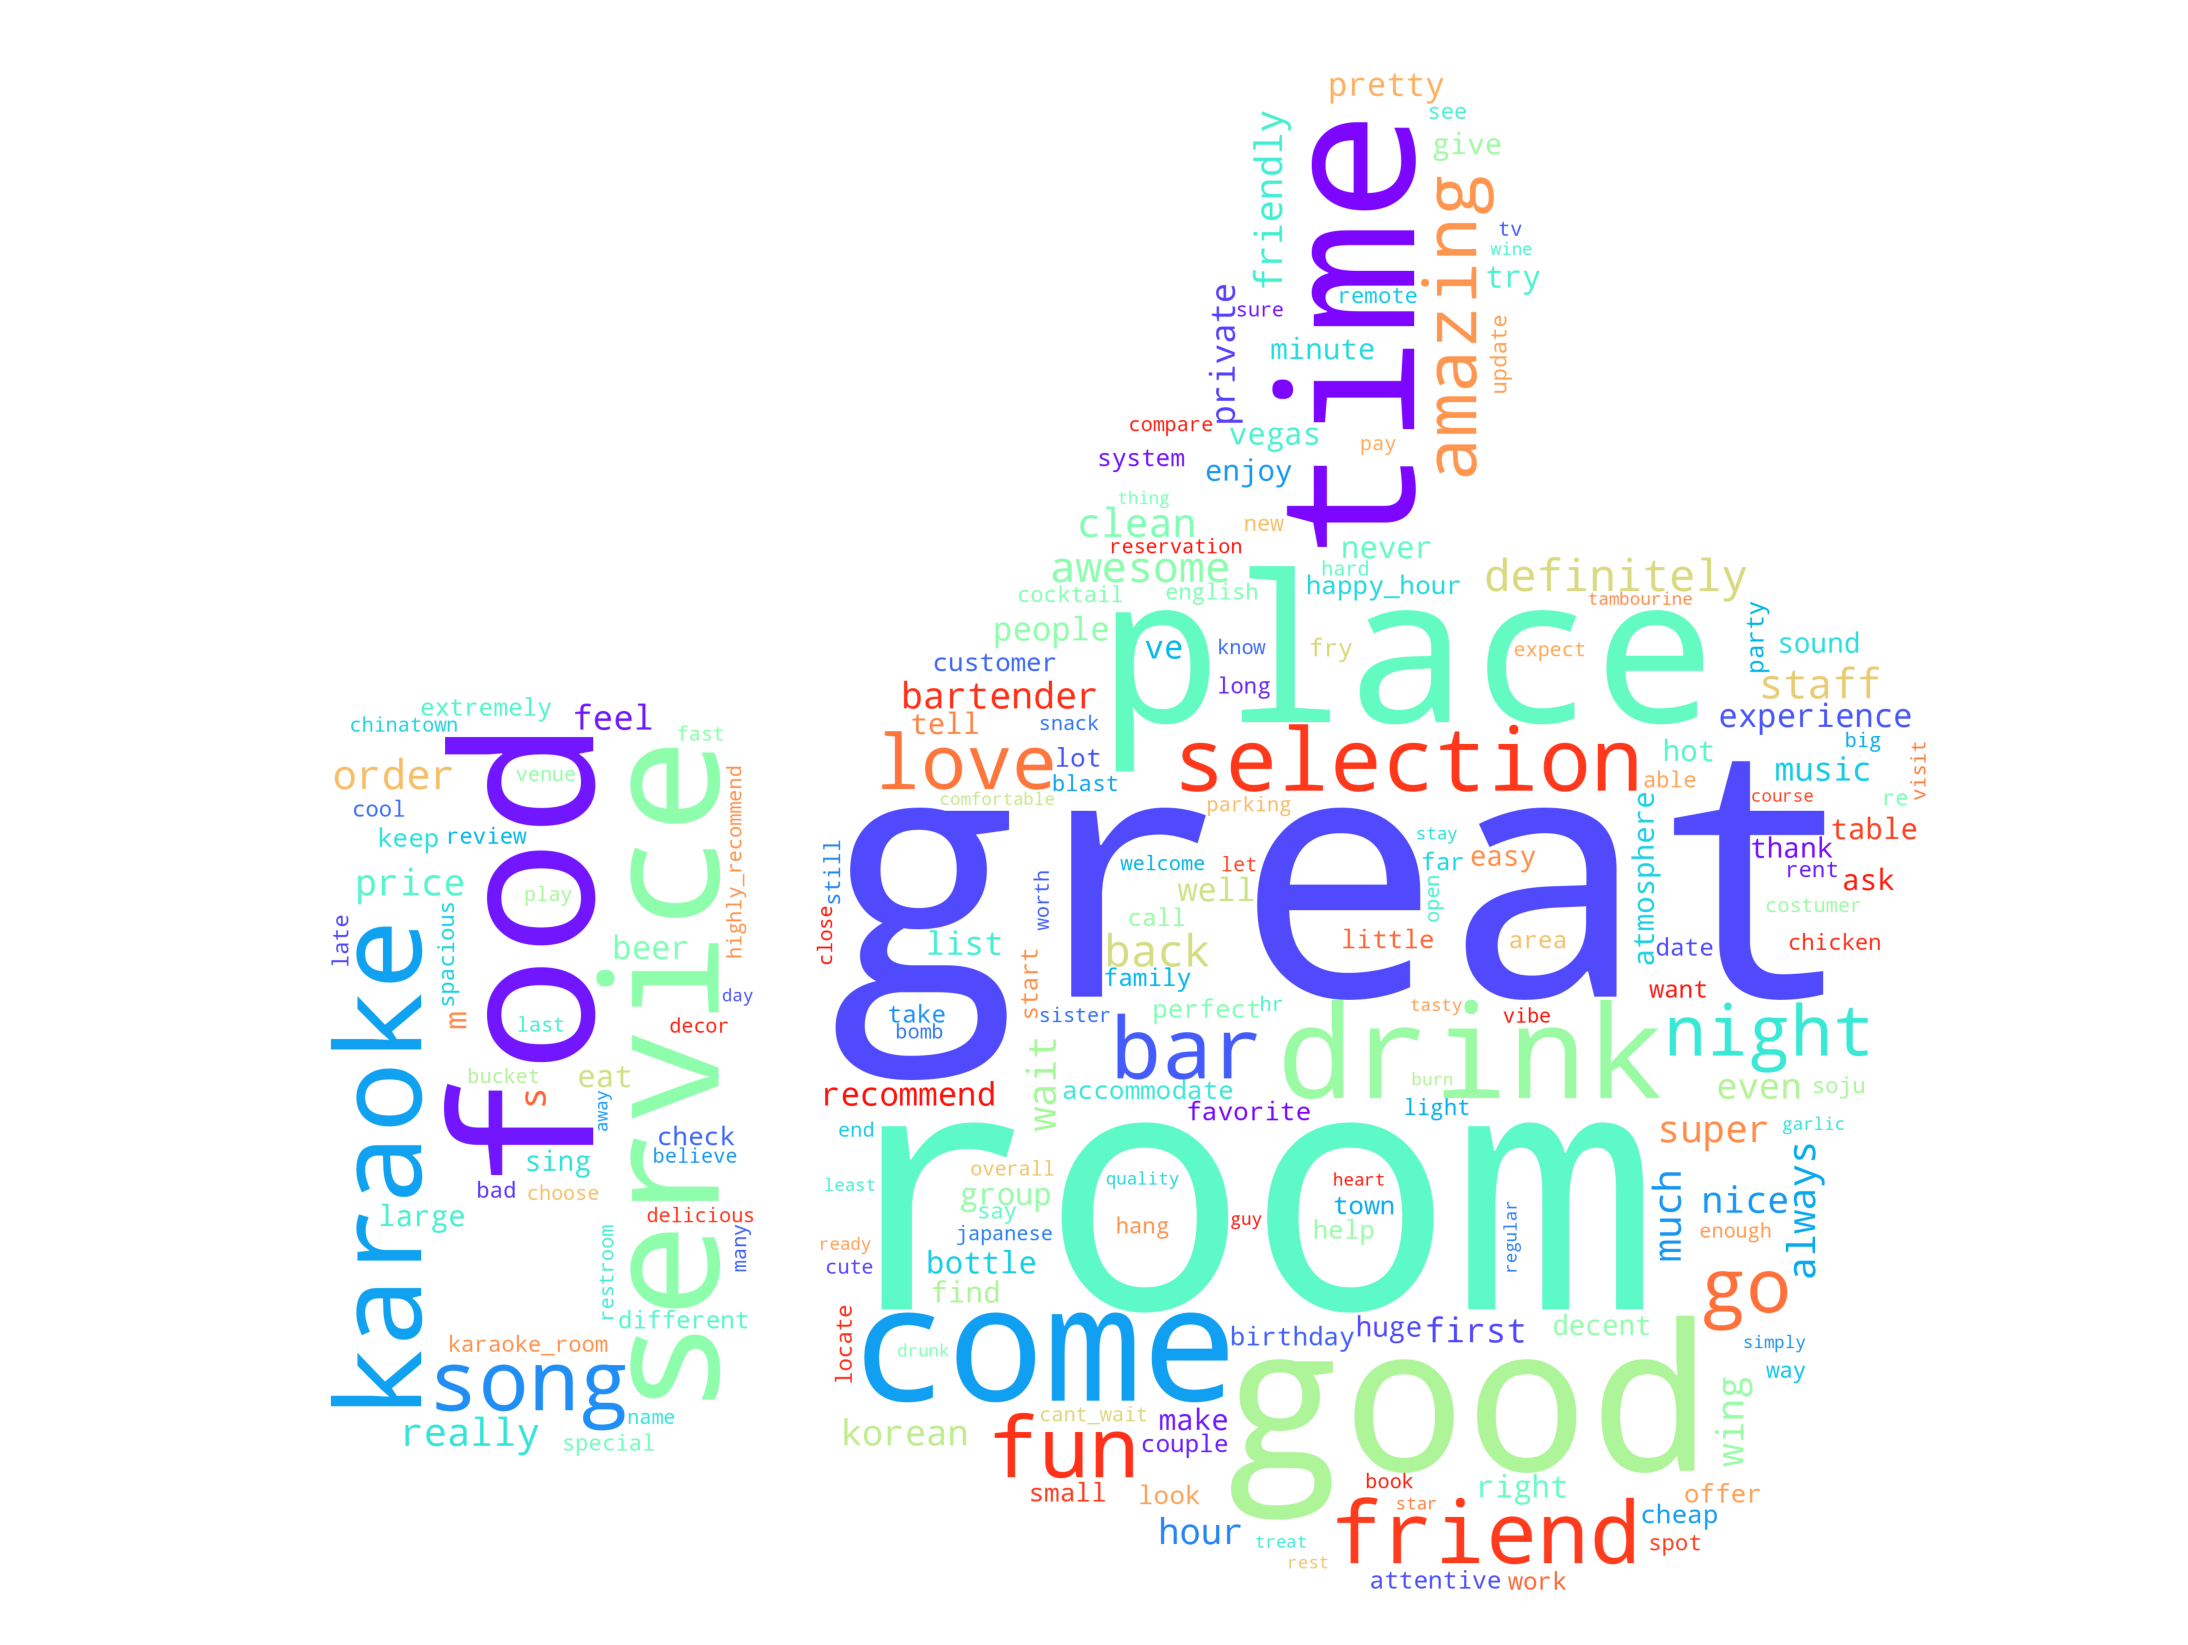

In [26]:
# Creating a word cloud for our restaurant
plot_wordcloud(data)

##Sentiment

Sentiment information for restaurant: "J Karaoke Bar" (3pSUr_cdrphurO6m1HMP9A)
the mean sentiment is 11.657142857142857
the mean positive sentiment is 12.257425742574258
the mean negative sentiment is -3.5
the number of positive sentiment is 101
the number of negative sentiment is 4
These are the descriptives of the sentiment:


count    105.000000
mean      11.657143
std        8.214467
min       -5.000000
25%        6.000000
50%       11.000000
75%       16.000000
max       38.000000
Name: afinn_score, dtype: float64

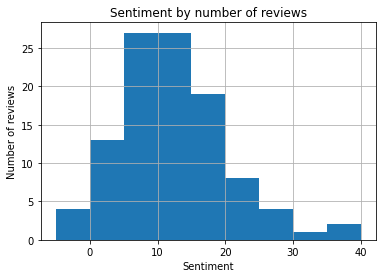

In [27]:
# sentimiento del cliente por el restaurante
print(f'Sentiment information for restaurant: {restaurant_name} ({selected_id})')
display_sentiment_inf(data)

## Words by Sentiment

Words in reviews related to positive_sentiment
Words in reviews related to negative_sentiment


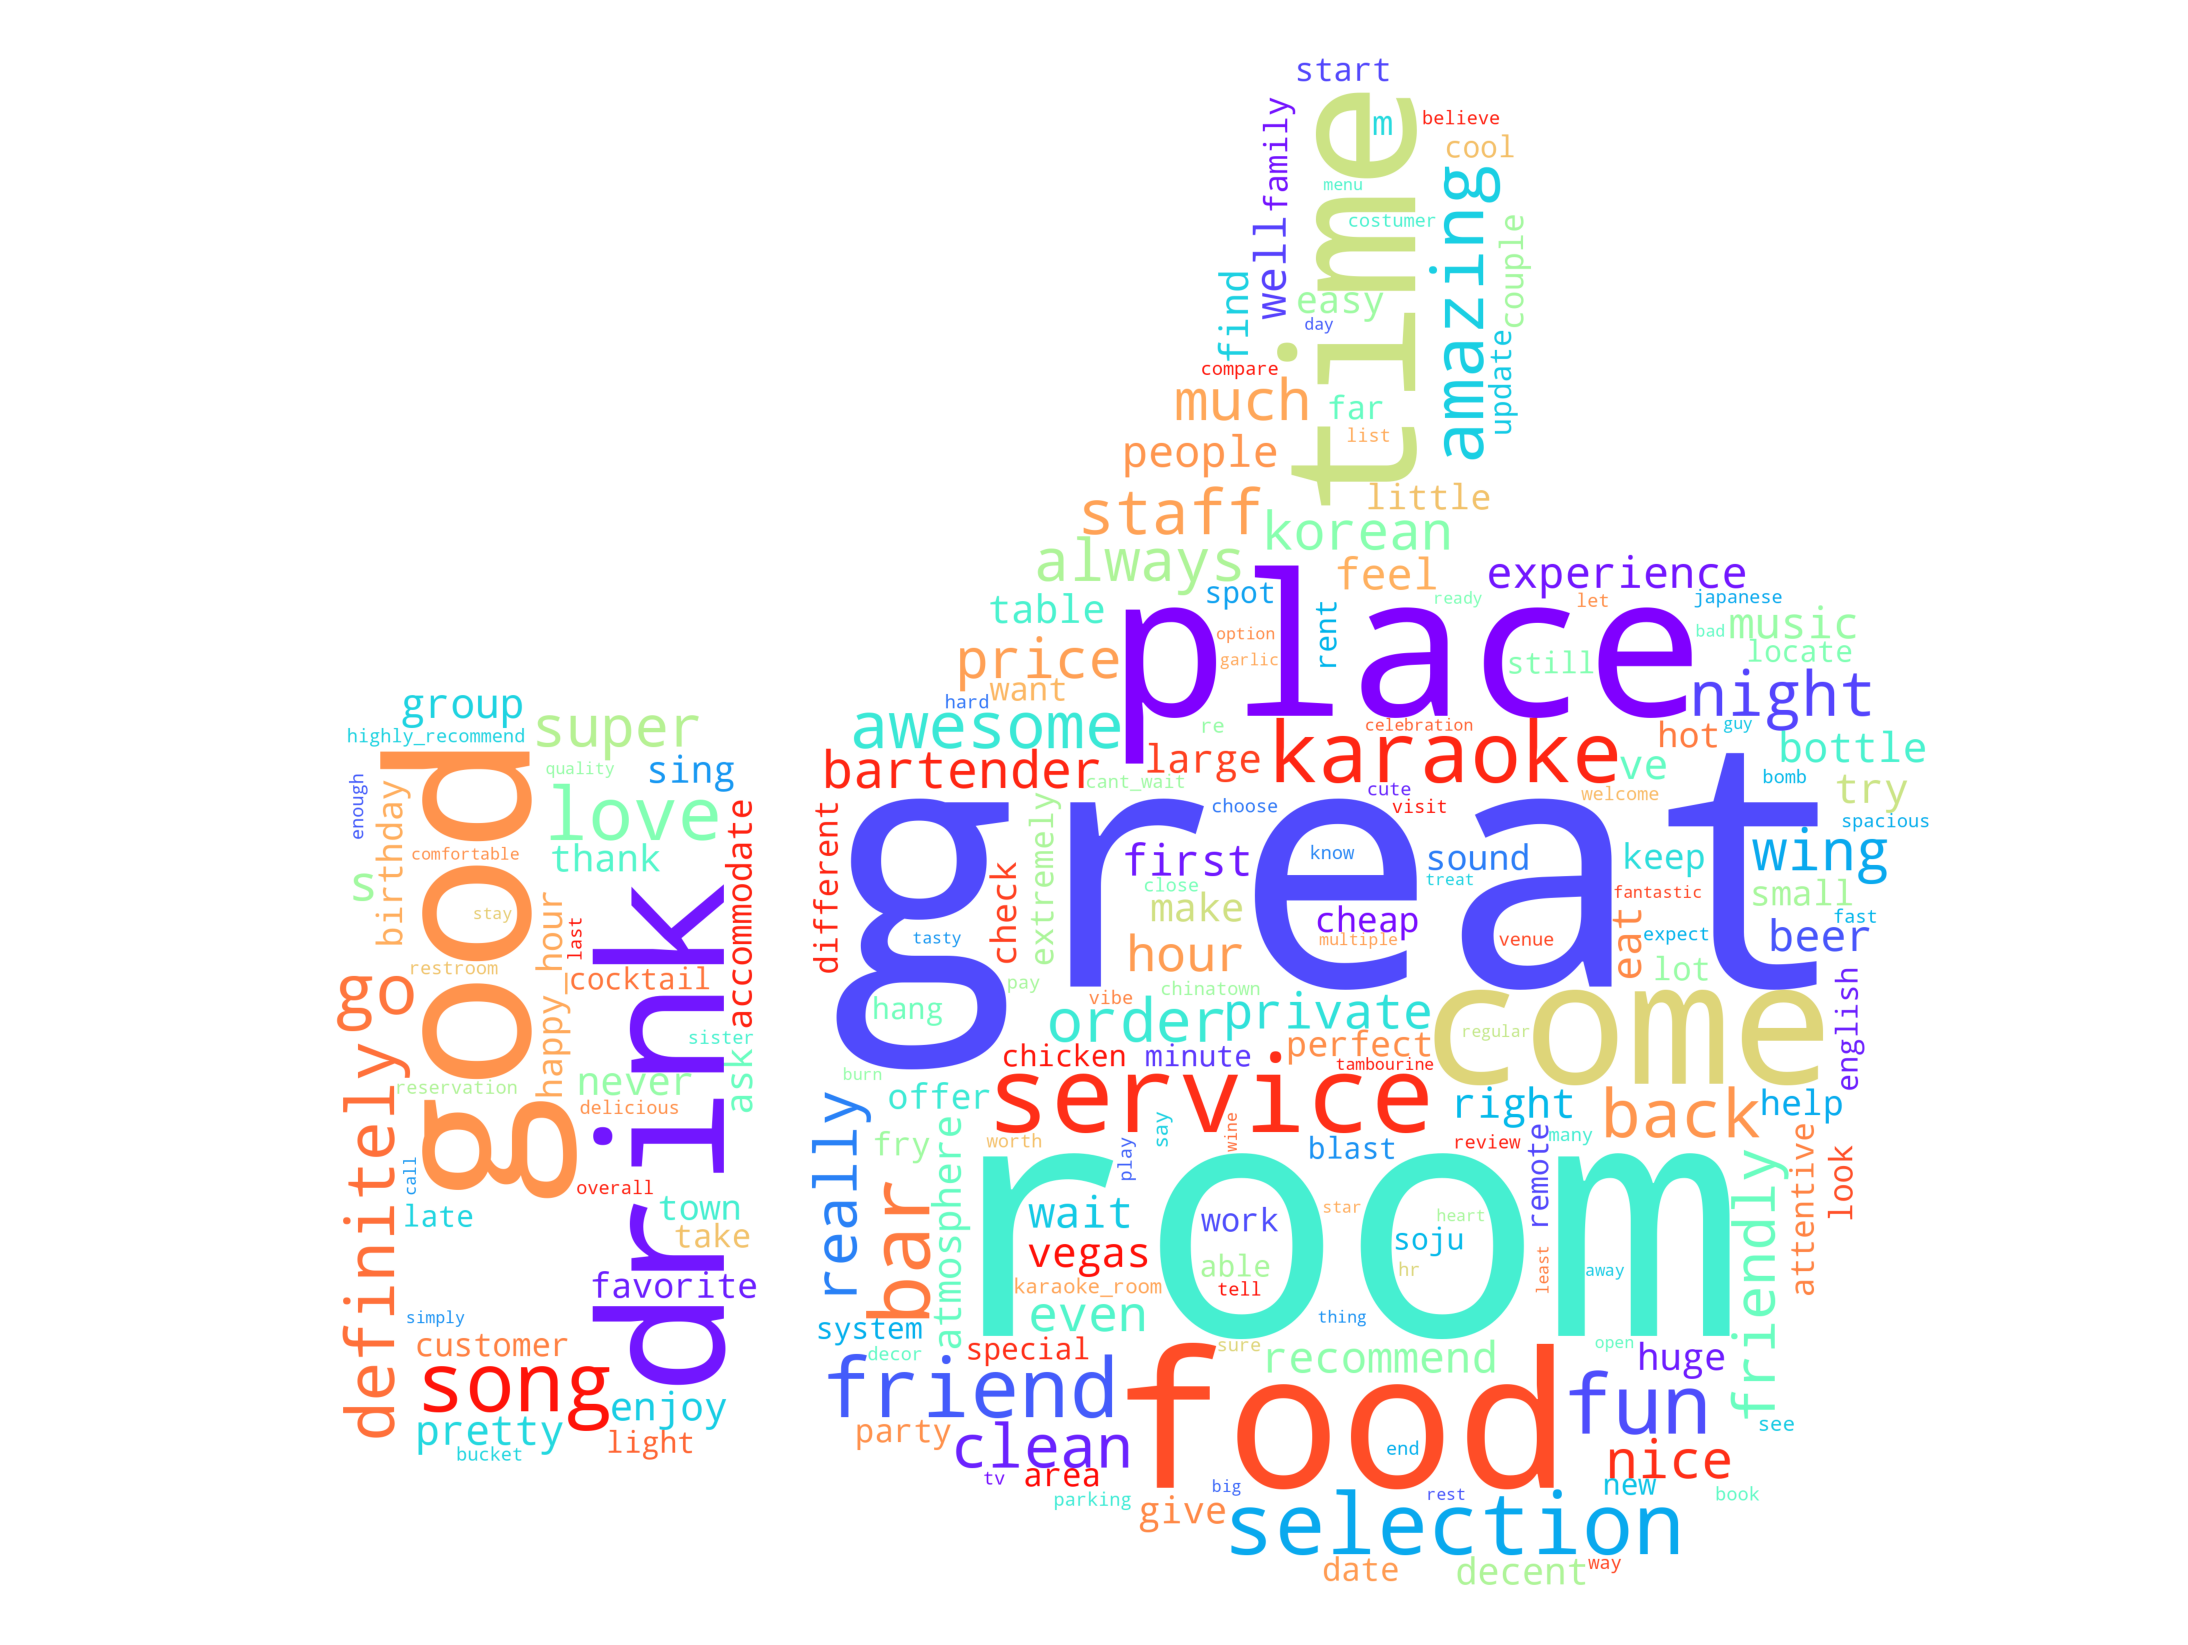

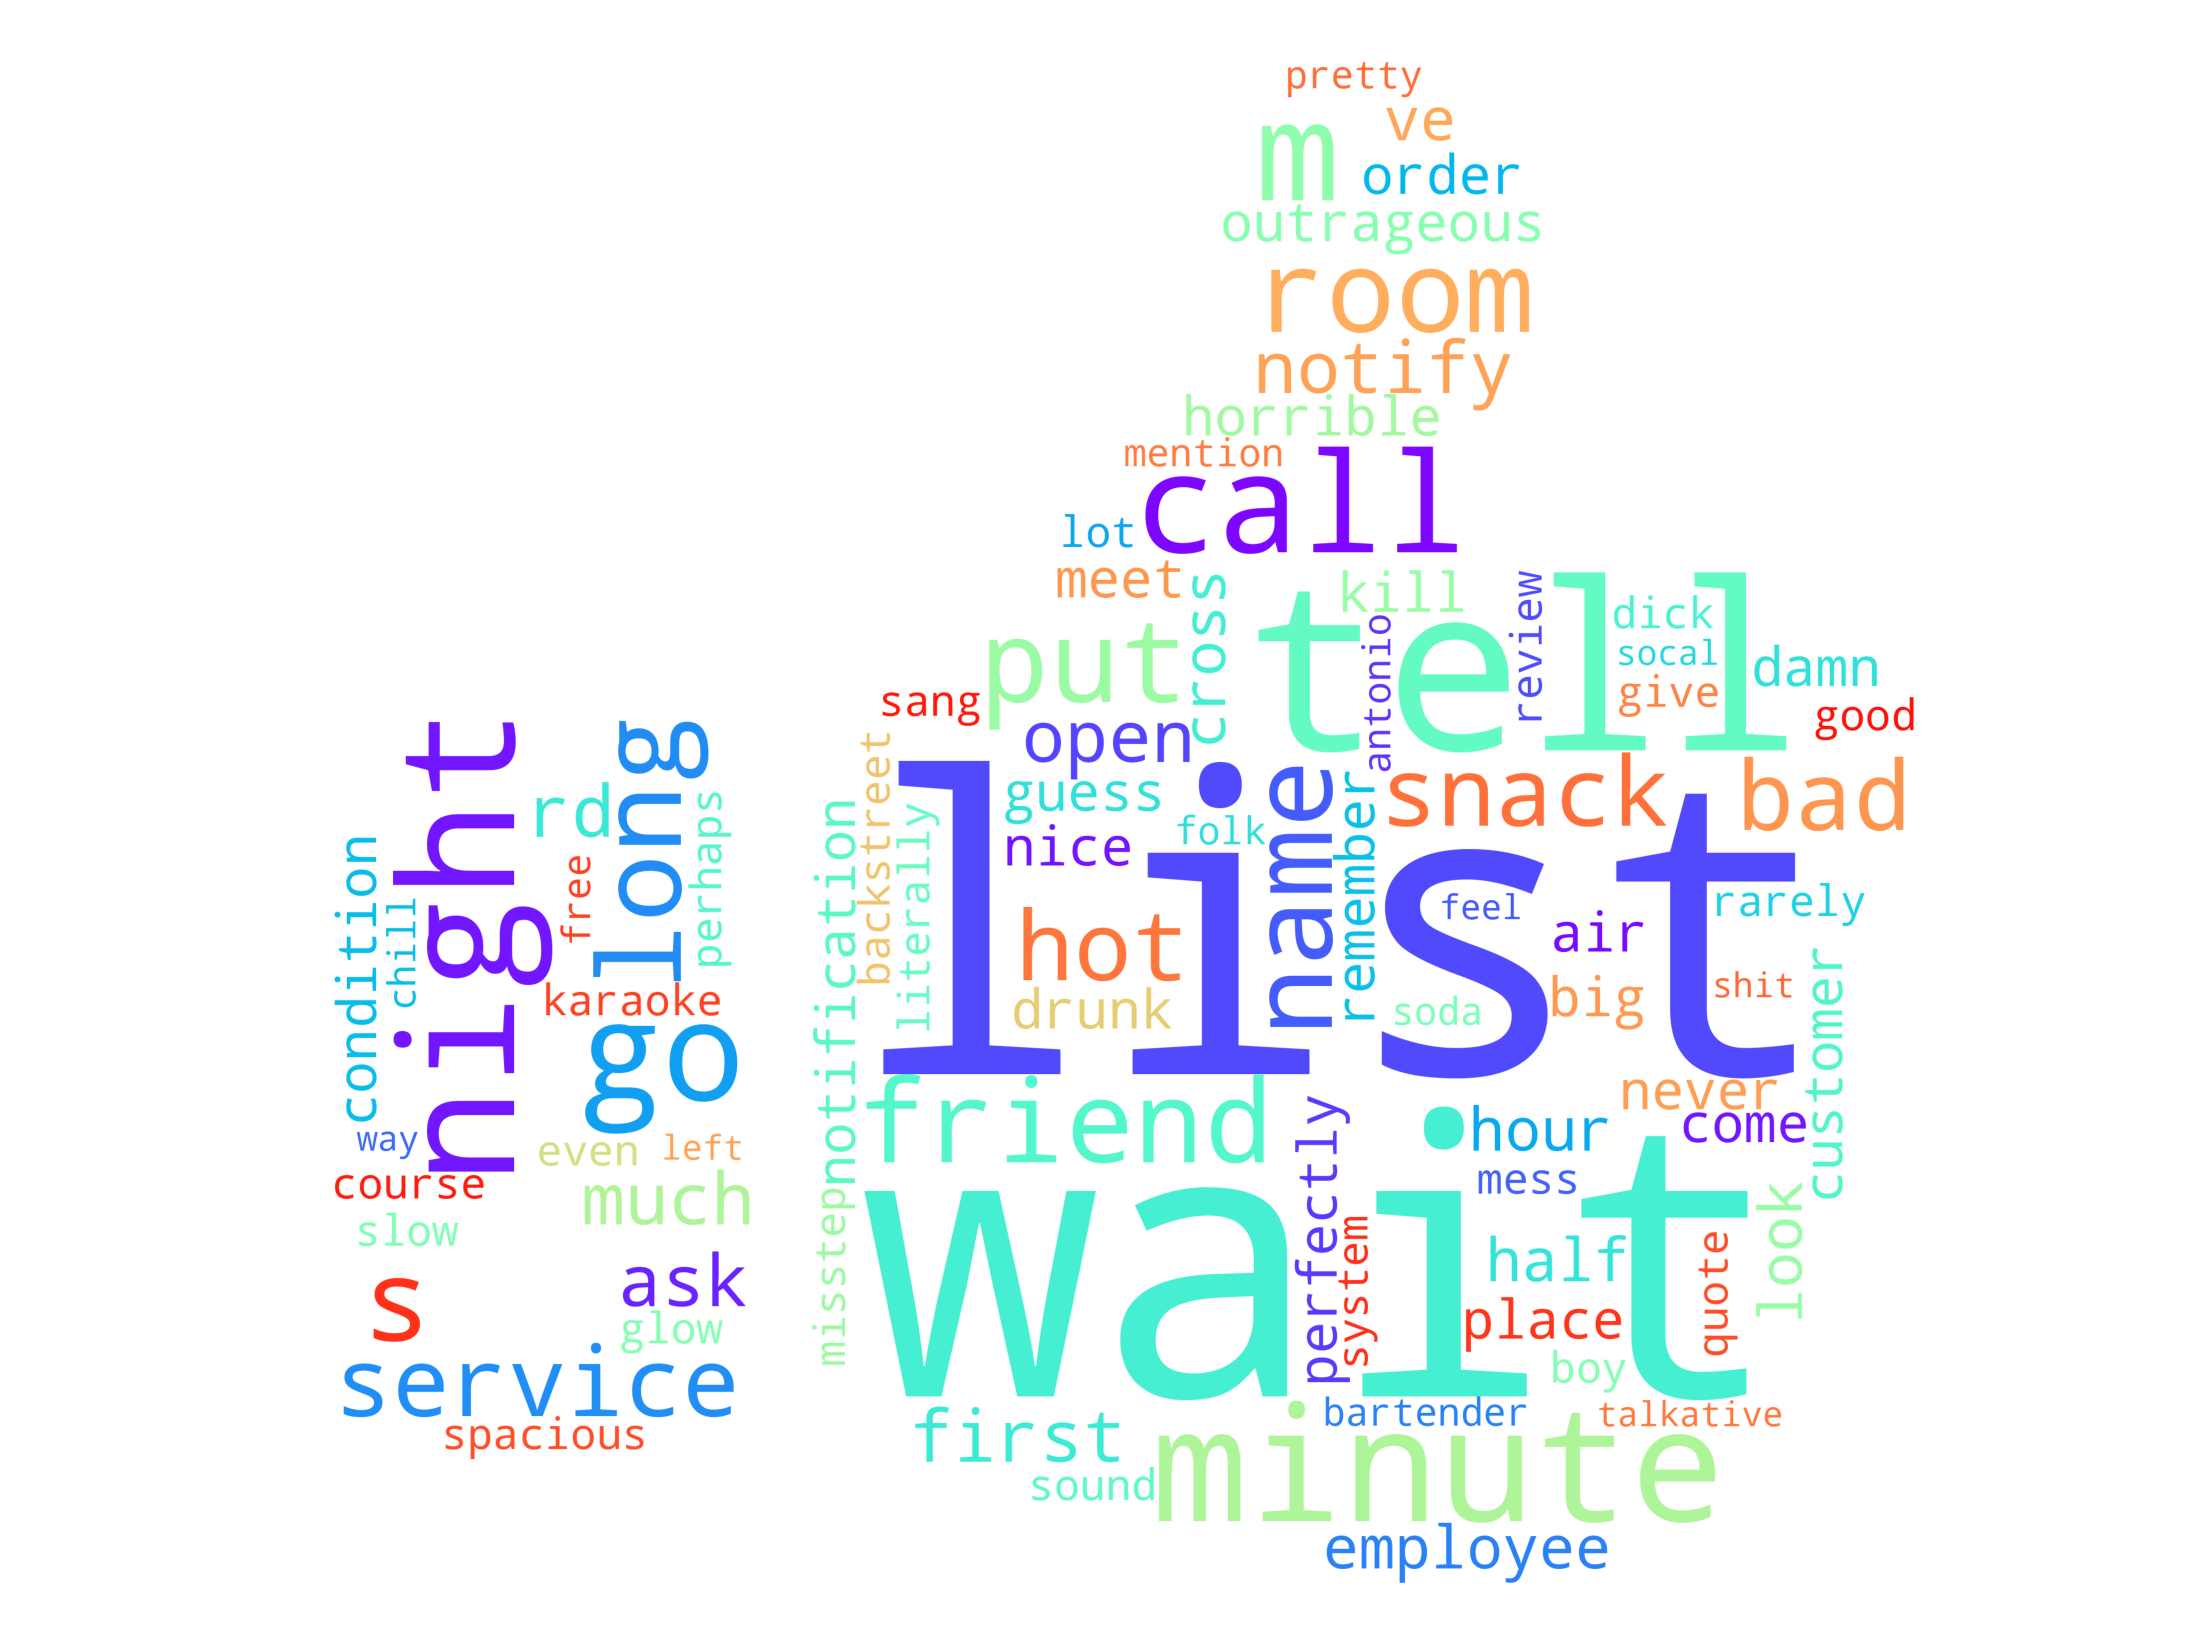

In [28]:
display_words_by_sentiment(data)